In [1]:
from Models.BaseCNN import BaseCNN
from Models.ResNet18 import ResNet18
from Models.EfficientNet_V2_S import EfficientNet_V2_S
from train_eval import trainNN, validateNN, train_and_validateNN, testNN
# from earlystop import EarlyStopper
from processes import initModel, trainModel, loadModel, plotTrain, saveModel, ypredToList, confMtx 
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## **Data Preparation**

In [2]:
# Read in data
img_size = 64
data_transformation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [3]:
dataset.class_to_idx

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [4]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(valid_data), len(test_data)

(17500, 5000, 2500)

In [5]:
# 'Colon Adenocarcinoma', 'Colon Benign', 'Lung Adenocarcinoma', 'Lung Benign', 'Lung Squamous Cell Caricnoma'
classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
#classes = ('lung_aca', 'lung_n', 'lung_scc')
# The function to show an image.
def display_img(ax, img, label):
    img = np.transpose(img.numpy(), (1, 2, 0))  # Change from (C,H,W) to (H,W,C)
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    img = stds * img + means  # Apply the reverse of normalization     # Unnormalize.
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis('off')

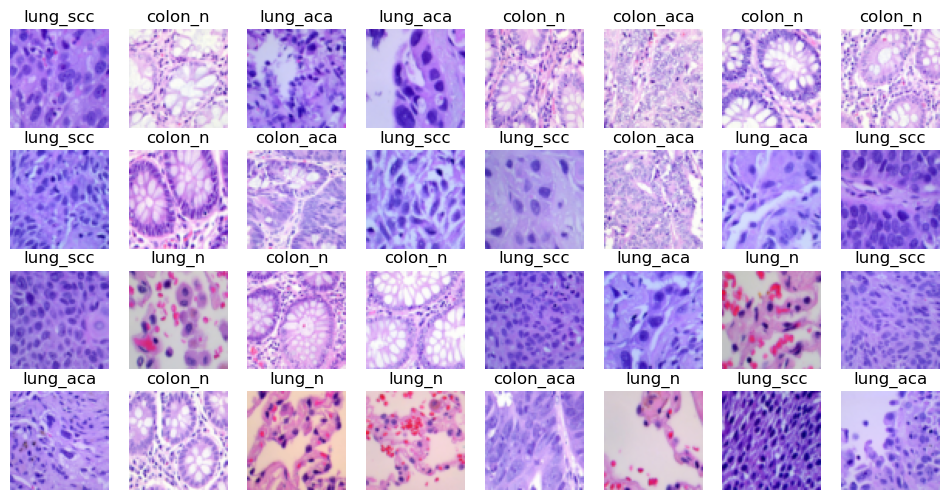

In [6]:
plt.figure(figsize=(12, 6))

# Get a random batch of training images.
images, labels = next(iter(train_loader))

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)  # Create a subplot for each image
    display_img(ax, images[i], labels[i])

In [7]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)  

mps


## **Training: BaseCNN Models**

In [8]:
num_epochs = 8
criterion = nn.CrossEntropyLoss()
lr = 0.001
num_classes = len(classes)

In [9]:
def w_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, .02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1, .02)
        nn.init.constant_(m.bias.data, 0)

### 1. ReLU + MaxPool

In [10]:
model = initModel('relu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss1, valid_loss1 = trainModel(model, 'relu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.631
Mini-batch (i: 200): Average mini-batch loss: 0.485
Mini-batch (i: 300): Average mini-batch loss: 0.456
Mini-batch (i: 400): Average mini-batch loss: 0.399
Mini-batch (i: 500): Average mini-batch loss: 0.378
End of Epoch 1 - train loss: 0.4593, valid loss: 0.3815
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.321
Mini-batch (i: 200): Average mini-batch loss: 0.315
Mini-batch (i: 300): Average mini-batch loss: 0.312
Mini-batch (i: 400): Average mini-batch loss: 0.283
Mini-batch (i: 500): Average mini-batch loss: 0.274
End of Epoch 2 - train loss: 0.3001, valid loss: 0.4190
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.260
Mini-batch (i: 200): Average mini-batch loss: 0.252
Mini-batch (i: 300): Average mini-batch loss: 0.250
Mini-batch (i: 400): Average mini-batch loss: 0.258
Mini-batch (i: 500): Average mini-batch loss: 0.227
End of Epoch 3 - train loss: 0.2461, valid loss: 0.2380
[Epoch 4/8]
Mini

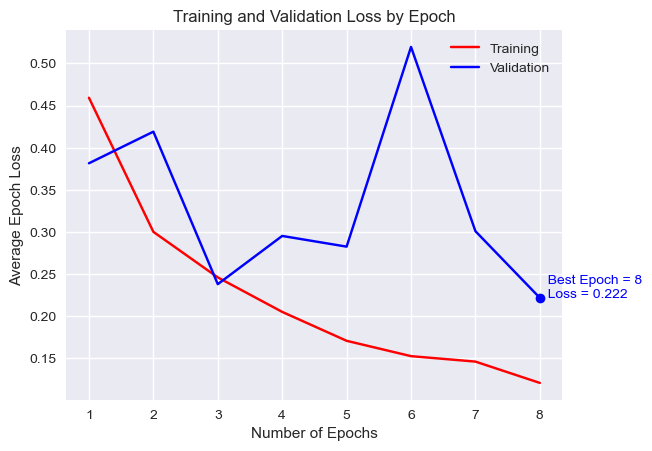

In [11]:
plotTrain(train_loss1, valid_loss1)

### 2. ReLU + AvgPool

In [12]:
model = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss2, valid_loss2 = trainModel(model, 'relu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.761
Mini-batch (i: 200): Average mini-batch loss: 0.646
Mini-batch (i: 300): Average mini-batch loss: 0.607
Mini-batch (i: 400): Average mini-batch loss: 0.594
Mini-batch (i: 500): Average mini-batch loss: 0.559
End of Epoch 1 - train loss: 0.6250, valid loss: 0.5522
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.507
Mini-batch (i: 200): Average mini-batch loss: 0.482
Mini-batch (i: 300): Average mini-batch loss: 0.450
Mini-batch (i: 400): Average mini-batch loss: 0.421
Mini-batch (i: 500): Average mini-batch loss: 0.433
End of Epoch 2 - train loss: 0.4540, valid loss: 0.4336
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.402
Mini-batch (i: 200): Average mini-batch loss: 0.364
Mini-batch (i: 300): Average mini-batch loss: 0.391
Mini-batch (i: 400): Average mini-batch loss: 0.360
Mini-batch (i: 500): Average mini-batch loss: 0.367
End of Epoch 3 - train loss: 0.3737, valid loss: 0.3779
[Epoch 4/8]
Mini

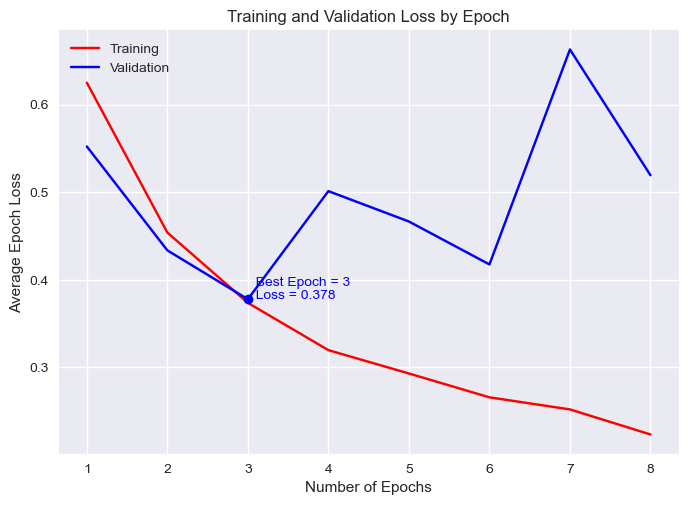

In [13]:
plotTrain(train_loss2, valid_loss2)

### 3. LeakyReLU + MaxPool

In [14]:
model = initModel('lrelu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss3, valid_loss3 = trainModel(model, 'lrelu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.671
Mini-batch (i: 200): Average mini-batch loss: 0.481
Mini-batch (i: 300): Average mini-batch loss: 0.474
Mini-batch (i: 400): Average mini-batch loss: 0.406
Mini-batch (i: 500): Average mini-batch loss: 0.348
End of Epoch 1 - train loss: 0.4631, valid loss: 0.7224
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.346
Mini-batch (i: 200): Average mini-batch loss: 0.300
Mini-batch (i: 300): Average mini-batch loss: 0.297
Mini-batch (i: 400): Average mini-batch loss: 0.297
Mini-batch (i: 500): Average mini-batch loss: 0.267
End of Epoch 2 - train loss: 0.2980, valid loss: 0.4111
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.253
Mini-batch (i: 200): Average mini-batch loss: 0.217
Mini-batch (i: 300): Average mini-batch loss: 0.251
Mini-batch (i: 400): Average mini-batch loss: 0.227
Mini-batch (i: 500): Average mini-batch loss: 0.229
End of Epoch 3 - train loss: 0.2329, valid loss: 0.3253
[Epoch 4/8]
Mini

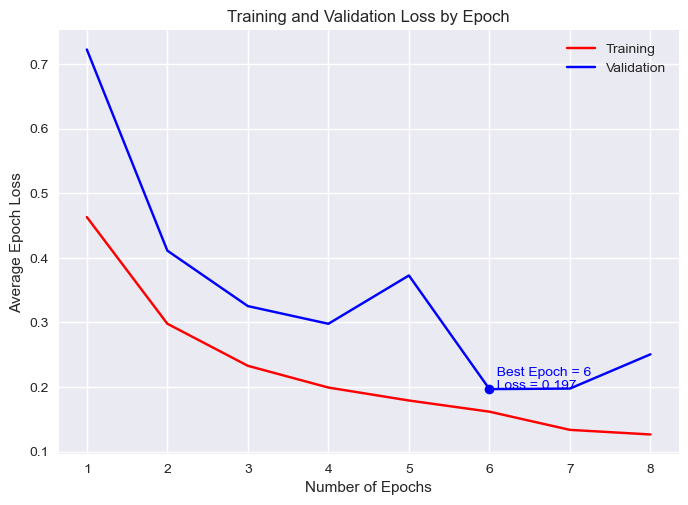

In [15]:
plotTrain(train_loss3, valid_loss3)

### 4. LeakyReLU + AvgPool

In [16]:
model = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss4, valid_loss4 = trainModel(model, 'lrelu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.718
Mini-batch (i: 200): Average mini-batch loss: 0.649
Mini-batch (i: 300): Average mini-batch loss: 0.623
Mini-batch (i: 400): Average mini-batch loss: 0.581
Mini-batch (i: 500): Average mini-batch loss: 0.540
End of Epoch 1 - train loss: 0.6128, valid loss: 0.5172
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.492
Mini-batch (i: 200): Average mini-batch loss: 0.472
Mini-batch (i: 300): Average mini-batch loss: 0.436
Mini-batch (i: 400): Average mini-batch loss: 0.431
Mini-batch (i: 500): Average mini-batch loss: 0.412
End of Epoch 2 - train loss: 0.4441, valid loss: 0.8992
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.397
Mini-batch (i: 200): Average mini-batch loss: 0.395
Mini-batch (i: 300): Average mini-batch loss: 0.369
Mini-batch (i: 400): Average mini-batch loss: 0.370
Mini-batch (i: 500): Average mini-batch loss: 0.333
End of Epoch 3 - train loss: 0.3676, valid loss: 0.4109
[Epoch 4/8]
Mini

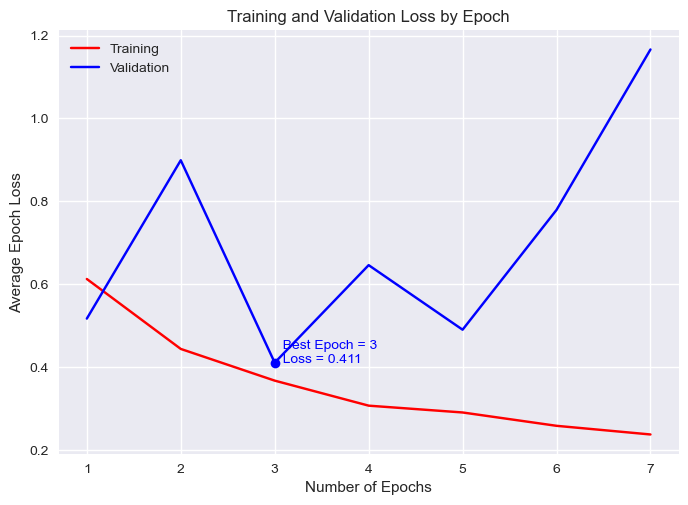

In [17]:
plotTrain(train_loss4, valid_loss4)

### 5. ELU + MaxPool

In [18]:
model = initModel('elu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss5, valid_loss5 = trainModel(model, 'elu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.646
Mini-batch (i: 200): Average mini-batch loss: 0.458
Mini-batch (i: 300): Average mini-batch loss: 0.452
Mini-batch (i: 400): Average mini-batch loss: 0.403
Mini-batch (i: 500): Average mini-batch loss: 0.362
End of Epoch 1 - train loss: 0.4569, valid loss: 0.5283
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.332
Mini-batch (i: 200): Average mini-batch loss: 0.318
Mini-batch (i: 300): Average mini-batch loss: 0.287
Mini-batch (i: 400): Average mini-batch loss: 0.291
Mini-batch (i: 500): Average mini-batch loss: 0.274
End of Epoch 2 - train loss: 0.2989, valid loss: 0.4988
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.269
Mini-batch (i: 200): Average mini-batch loss: 0.252
Mini-batch (i: 300): Average mini-batch loss: 0.237
Mini-batch (i: 400): Average mini-batch loss: 0.267
Mini-batch (i: 500): Average mini-batch loss: 0.232
End of Epoch 3 - train loss: 0.2504, valid loss: 0.2095
[Epoch 4/8]
Mini

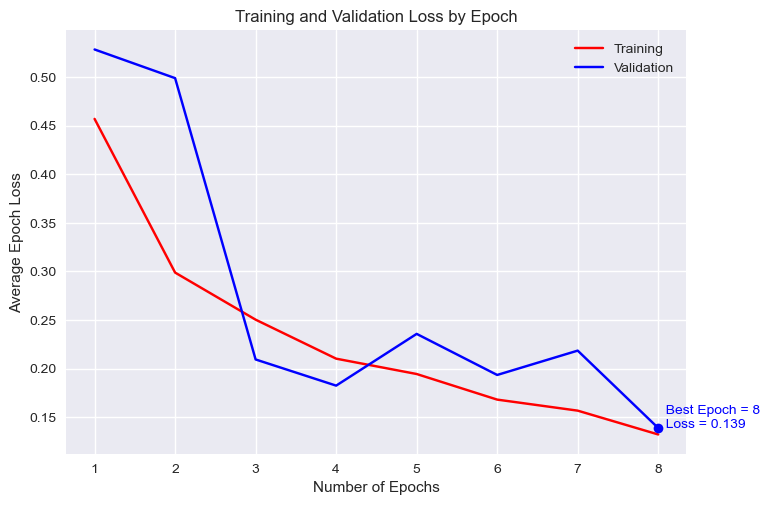

In [19]:
plotTrain(train_loss5, valid_loss5)

### 6. ELU + AvgPool

In [20]:
model = initModel('elu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss6, valid_loss6 = trainModel(model, 'elu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.774
Mini-batch (i: 200): Average mini-batch loss: 0.628
Mini-batch (i: 300): Average mini-batch loss: 0.623
Mini-batch (i: 400): Average mini-batch loss: 0.593
Mini-batch (i: 500): Average mini-batch loss: 0.562
End of Epoch 1 - train loss: 0.6295, valid loss: 0.5495
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.546
Mini-batch (i: 200): Average mini-batch loss: 0.526
Mini-batch (i: 300): Average mini-batch loss: 0.513
Mini-batch (i: 400): Average mini-batch loss: 0.466
Mini-batch (i: 500): Average mini-batch loss: 0.477
End of Epoch 2 - train loss: 0.4999, valid loss: 0.3774
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.410
Mini-batch (i: 200): Average mini-batch loss: 0.430
Mini-batch (i: 300): Average mini-batch loss: 0.421
Mini-batch (i: 400): Average mini-batch loss: 0.375
Mini-batch (i: 500): Average mini-batch loss: 0.399
End of Epoch 3 - train loss: 0.4021, valid loss: 0.3380
[Epoch 4/8]
Mini

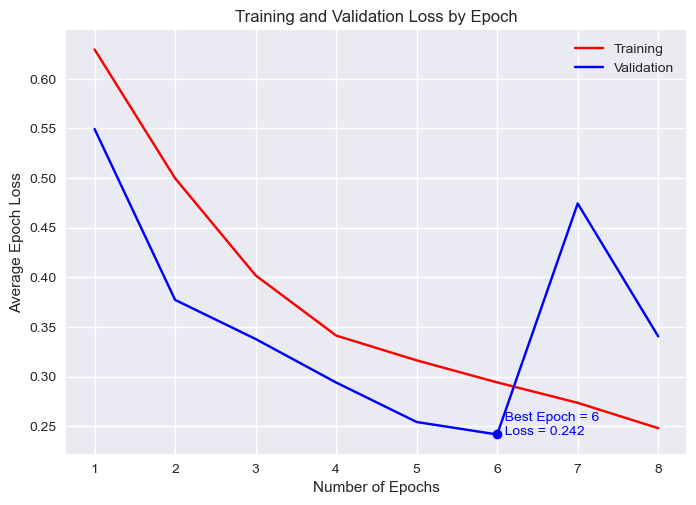

In [21]:
plotTrain(train_loss6, valid_loss6)

## **Training: ResNet18 and EfficientNetV2_S**

### ResNet18

In [ ]:
model = ResNet18(num_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss7, valid_loss7 = trainModel(model, None, None, img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)
saveModel(model, 'resnet18')

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.357
Mini-batch (i: 200): Average mini-batch loss: 0.229
Mini-batch (i: 300): Average mini-batch loss: 0.179
Mini-batch (i: 400): Average mini-batch loss: 0.165
Mini-batch (i: 500): Average mini-batch loss: 0.119
End of Epoch 1 - train loss: 0.2025, valid loss: 0.1285
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.139
Mini-batch (i: 200): Average mini-batch loss: 0.114
Mini-batch (i: 300): Average mini-batch loss: 0.175
Mini-batch (i: 400): Average mini-batch loss: 0.080
Mini-batch (i: 500): Average mini-batch loss: 0.091
End of Epoch 2 - train loss: 0.1174, valid loss: 0.1222
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.080
Mini-batch (i: 200): Average mini-batch loss: 0.072
Mini-batch (i: 300): Average mini-batch loss: 0.081
Mini-batch (i: 400): Average mini-batch loss: 0.080
Mini-batch (i: 500): Average mini-batch loss: 0.087
End of Epoch 3 - train loss: 0.0884, valid loss: 0.4203
[Epoch 4/8]
Mini

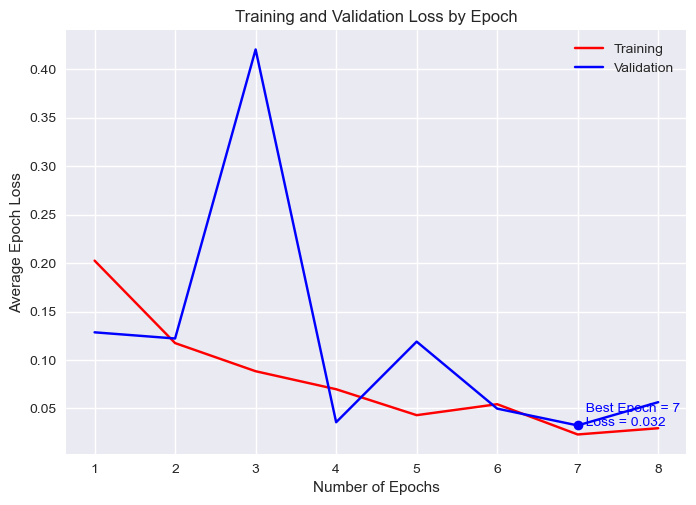

In [ ]:
plotTrain(train_loss7, valid_loss7)

### EfficientNet_V2_S

In [ ]:
model = EfficientNet_V2_S(num_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss8, valid_loss8 = trainModel(model, None, None, img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)
saveModel(model, 'effnetV2_S')

[Epoch 1/8]
Mini-batch (i: 100): Average mini-batch loss: 0.431
Mini-batch (i: 200): Average mini-batch loss: 0.205
Mini-batch (i: 300): Average mini-batch loss: 0.151
Mini-batch (i: 400): Average mini-batch loss: 0.115
Mini-batch (i: 500): Average mini-batch loss: 0.127
End of Epoch 1 - train loss: 0.1973, valid loss: 0.0593
[Epoch 2/8]
Mini-batch (i: 100): Average mini-batch loss: 0.052
Mini-batch (i: 200): Average mini-batch loss: 0.097
Mini-batch (i: 300): Average mini-batch loss: 0.073
Mini-batch (i: 400): Average mini-batch loss: 0.060
Mini-batch (i: 500): Average mini-batch loss: 0.133
End of Epoch 2 - train loss: 0.0865, valid loss: 0.0721
[Epoch 3/8]
Mini-batch (i: 100): Average mini-batch loss: 0.064
Mini-batch (i: 200): Average mini-batch loss: 0.051
Mini-batch (i: 300): Average mini-batch loss: 0.102
Mini-batch (i: 400): Average mini-batch loss: 0.077
Mini-batch (i: 500): Average mini-batch loss: 0.067
End of Epoch 3 - train loss: 0.0730, valid loss: 0.0557
[Epoch 4/8]
Mini

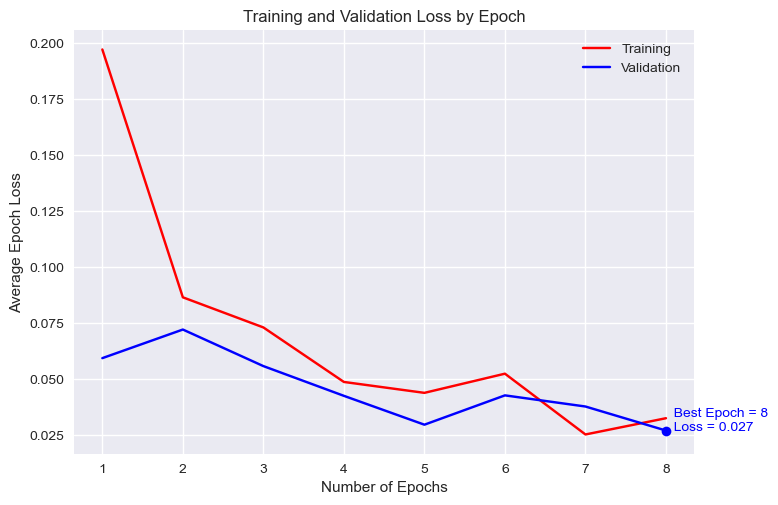

In [ ]:
plotTrain(train_loss8, valid_loss8)

## **Validation: BaseCNN Models**

In [10]:
# def loadModel(model_name, activation, pooling, img_size, test_loader, classes, device):
#     if model_name == 'resnet18':
#         model = ResNet18(len(classes))
#         model.load_state_dict(torch.load(f'{model_name}.pt'))
#         model = model.to(device)
#     elif model_name == 'effnetV2_S':
#         model = EfficientNet_V2_S(len(classes))
#         model.load_state_dict(torch.load(f'{model_name}.pt'))
#         model = model.to(device)
#     else:
#         model = BaseCNN(activation, pooling, img_size, elu_val = 1, lrelu_val = 0.01)
#         model.load_state_dict(torch.load(f'{activation}-{pooling}.pt'))
#         model = model.to(device)

#     return testNN(model, test_loader, classes, device)

### 1. ReLU + MaxPool

In [11]:
_, valid_acc1, _ = loadModel('baseCNN','relu', 'max', img_size, valid_loader, classes, device)

Accuracy for colon_aca: 99.1%
Accuracy for colon_n: 83.3%
Accuracy for lung_aca: 95.3%
Accuracy for lung_n: 93.0%
Accuracy for lung_scc: 88.0%
Overall Model Accuracy: 91.8%


### 2. ReLU + AvgPool

In [12]:
_, valid_acc2, _ = loadModel('baseCNN','relu', 'avg', img_size, valid_loader, classes, device)

Accuracy for colon_aca: 91.9%
Accuracy for colon_n: 3.1%
Accuracy for lung_aca: 81.7%
Accuracy for lung_n: 94.2%
Accuracy for lung_scc: 95.9%
Overall Model Accuracy: 73.7%


### 3. LeakyReLU + MaxPool

In [13]:
_, valid_acc3, _ = loadModel('baseCNN','lrelu', 'max', img_size, valid_loader, classes, device)

Accuracy for colon_aca: 79.9%
Accuracy for colon_n: 98.9%
Accuracy for lung_aca: 89.7%
Accuracy for lung_n: 99.8%
Accuracy for lung_scc: 79.1%
Overall Model Accuracy: 89.5%


### 4. LeakyReLU + AvgPool

In [14]:
_, valid_acc4, _ = loadModel('baseCNN','lrelu', 'avg', img_size, valid_loader, classes, device)

Accuracy for colon_aca: 92.2%
Accuracy for colon_n: 0.0%
Accuracy for lung_aca: 54.6%
Accuracy for lung_n: 93.6%
Accuracy for lung_scc: 98.9%
Overall Model Accuracy: 68.0%


### 5. ELU + MaxPool

In [15]:
_, valid_acc5, _ = loadModel('baseCNN','elu', 'max', img_size, valid_loader, classes, device)

Accuracy for colon_aca: 96.3%
Accuracy for colon_n: 98.9%
Accuracy for lung_aca: 84.4%
Accuracy for lung_n: 99.7%
Accuracy for lung_scc: 96.1%
Overall Model Accuracy: 95.0%


### 6. ELU + AvgPool

In [16]:
_, valid_acc6, _ = loadModel('baseCNN','elu', 'avg', img_size, valid_loader, classes, device)

Accuracy for colon_aca: 91.4%
Accuracy for colon_n: 91.4%
Accuracy for lung_aca: 59.5%
Accuracy for lung_n: 94.6%
Accuracy for lung_scc: 89.6%
Overall Model Accuracy: 85.1%


## **Validation: ResNet18 and EfficientNetV2_S**

### ResNet18

In [17]:
_, valid_acc7, _ = loadModel('resnet18', None, None, img_size, valid_loader, classes, device)

Accuracy for colon_aca: 97.1%
Accuracy for colon_n: 99.9%
Accuracy for lung_aca: 98.6%
Accuracy for lung_n: 99.5%
Accuracy for lung_scc: 99.1%
Overall Model Accuracy: 98.8%


### EfficientNet_V2_S

In [18]:
_, valid_acc8, _ = loadModel('effnetV2_S', None, None, img_size, valid_loader, classes, device)

Accuracy for colon_aca: 100.0%
Accuracy for colon_n: 100.0%
Accuracy for lung_aca: 97.8%
Accuracy for lung_n: 100.0%
Accuracy for lung_scc: 99.5%
Overall Model Accuracy: 99.4%


## **Evaluate Top 3 Models on Testing Data**

According to validation dataset, the top 3 models are:
1. EfficientNetV2_S
2. ResNet18
3. ELU-MaxPool BaseCNN

In [19]:
y_true = [] # Get true labels from test_loader
for data, labels in test_loader:
    y_true.extend(labels.tolist())

### a) ELU + MaxPool

Accuracy for colon_aca: 97.4%
Accuracy for colon_n: 97.0%
Accuracy for lung_aca: 84.3%
Accuracy for lung_n: 99.8%
Accuracy for lung_scc: 97.9%
Overall Model Accuracy: 95.4%


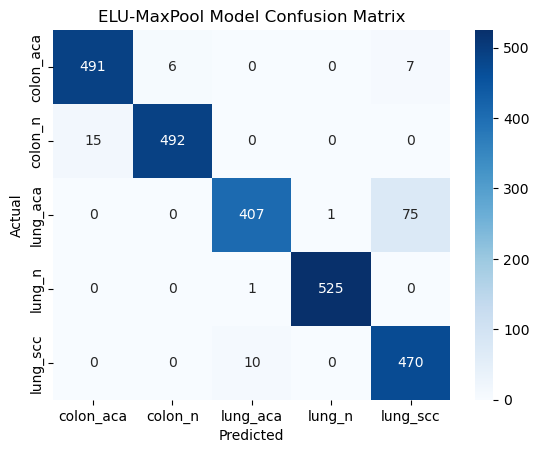

              precision    recall  f1-score   support

   colon_aca       0.97      0.97      0.97       504
     colon_n       0.99      0.97      0.98       507
    lung_aca       0.97      0.84      0.90       483
      lung_n       1.00      1.00      1.00       526
    lung_scc       0.85      0.98      0.91       480

    accuracy                           0.95      2500
   macro avg       0.96      0.95      0.95      2500
weighted avg       0.96      0.95      0.95      2500



In [20]:
_, _, elu_max_preds = loadModel('baseCNN', 'elu', 'max', img_size, test_loader, classes, device)
elu_max_preds = ypredToList(elu_max_preds)
confMtx(y_true, elu_max_preds, 'ELU-MaxPool', classes)
print(classification_report(y_true, elu_max_preds, target_names=classes))

### b) ResNet18

Accuracy for colon_aca: 96.2%
Accuracy for colon_n: 99.6%
Accuracy for lung_aca: 98.1%
Accuracy for lung_n: 99.8%
Accuracy for lung_scc: 97.7%
Overall Model Accuracy: 98.3%


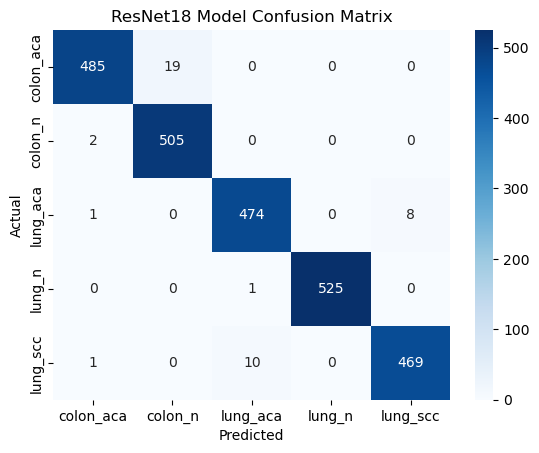

              precision    recall  f1-score   support

   colon_aca       0.99      0.96      0.98       504
     colon_n       0.96      1.00      0.98       507
    lung_aca       0.98      0.98      0.98       483
      lung_n       1.00      1.00      1.00       526
    lung_scc       0.98      0.98      0.98       480

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



In [23]:
_, _, resnet18_preds = loadModel('resnet18', None, None, img_size, test_loader, classes, device)
resnet18_preds = ypredToList(resnet18_preds)
confMtx(y_true, resnet18_preds, 'ResNet18', classes)
print(classification_report(y_true, resnet18_preds, target_names=classes))

### c) EfficientNet_V2_S

Accuracy for colon_aca: 100.0%
Accuracy for colon_n: 100.0%
Accuracy for lung_aca: 99.2%
Accuracy for lung_n: 100.0%
Accuracy for lung_scc: 100.0%
Overall Model Accuracy: 99.8%


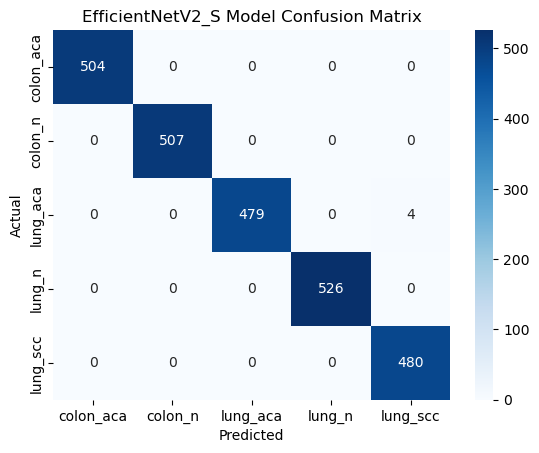

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       504
     colon_n       1.00      1.00      1.00       507
    lung_aca       1.00      0.99      1.00       483
      lung_n       1.00      1.00      1.00       526
    lung_scc       0.99      1.00      1.00       480

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [25]:
_, _, effnetV2_preds = loadModel('effnetV2_S', None, None, img_size, test_loader, classes, device)
effnetV2_preds = ypredToList(effnetV2_preds)
confMtx(y_true, effnetV2_preds, 'EfficientNetV2_S', classes)
print(classification_report(y_true, effnetV2_preds, target_names=classes))